In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn, os,csv
from scipy.io import arff
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
import lightgbm as lgb
import optuna
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
os.listdir("dataset/Time Series/Multi-variate/")

['eye state',
 'individual household electric ower consumption',
 'occupancy+detection']

In [3]:
source='dataset/Time Series/Multi-variate/'

In [17]:
data, meta = arff.loadarff(source + 'eye state/EEG Eye State.arff')
df1 = pd.DataFrame(data)

In [18]:
df1.dtypes, df1.shape

(AF3             float64
 F7              float64
 F3              float64
 FC5             float64
 T7              float64
 P7              float64
 O1              float64
 O2              float64
 P8              float64
 T8              float64
 FC6             float64
 F4              float64
 F8              float64
 AF4             float64
 eyeDetection     object
 dtype: object,
 (14980, 15))

In [19]:
df1

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,b'0'
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,b'0'
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,b'0'
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,b'0'
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,b'0'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14975,4281.03,3990.26,4245.64,4116.92,4333.85,4614.36,4074.87,4625.64,4203.08,4221.54,4171.28,4269.23,4593.33,4340.51,b'1'
14976,4276.92,3991.79,4245.13,4110.77,4332.82,4615.38,4073.33,4621.54,4194.36,4217.44,4162.56,4259.49,4590.26,4333.33,b'1'
14977,4277.44,3990.77,4246.67,4113.85,4333.33,4615.38,4072.82,4623.59,4193.33,4212.82,4160.51,4257.95,4591.79,4339.49,b'1'
14978,4284.62,3991.79,4251.28,4122.05,4334.36,4616.41,4080.51,4628.72,4200.00,4220.00,4165.64,4267.18,4596.41,4350.77,b'1'


In [11]:
df1.isna().sum()

AF3             0
F7              0
F3              0
FC5             0
T7              0
P7              0
O1              0
O2              0
P8              0
T8              0
FC6             0
F4              0
F8              0
AF4             0
eyeDetection    0
dtype: int64

In [19]:
adf_results = {}
for column in df1.columns:
    result = sm.tsa.adfuller(df1[column].dropna())
    adf_results[column] = {
        'ADF Statistic': result[0],
        'p-value': result[1],
        'Critical Values': result[4]
    }

In [22]:
if result[1] <= 0.05:
    print("The data is stationary.")
else:
    print("The data is non-stationary.")

The data is stationary.


Text(0.5, 1.0, 'Target distribution')

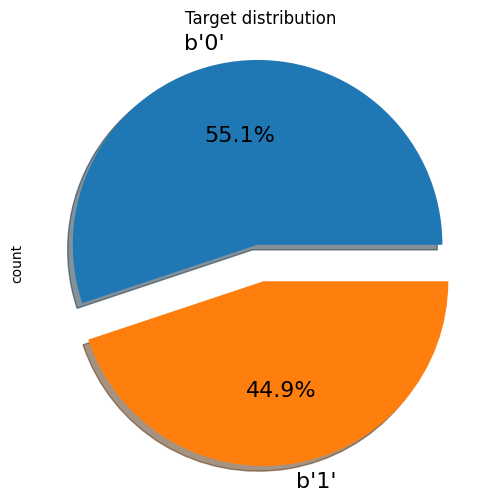

In [23]:
plt.figure(figsize=(6,6))
df1['eyeDetection'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Target distribution")

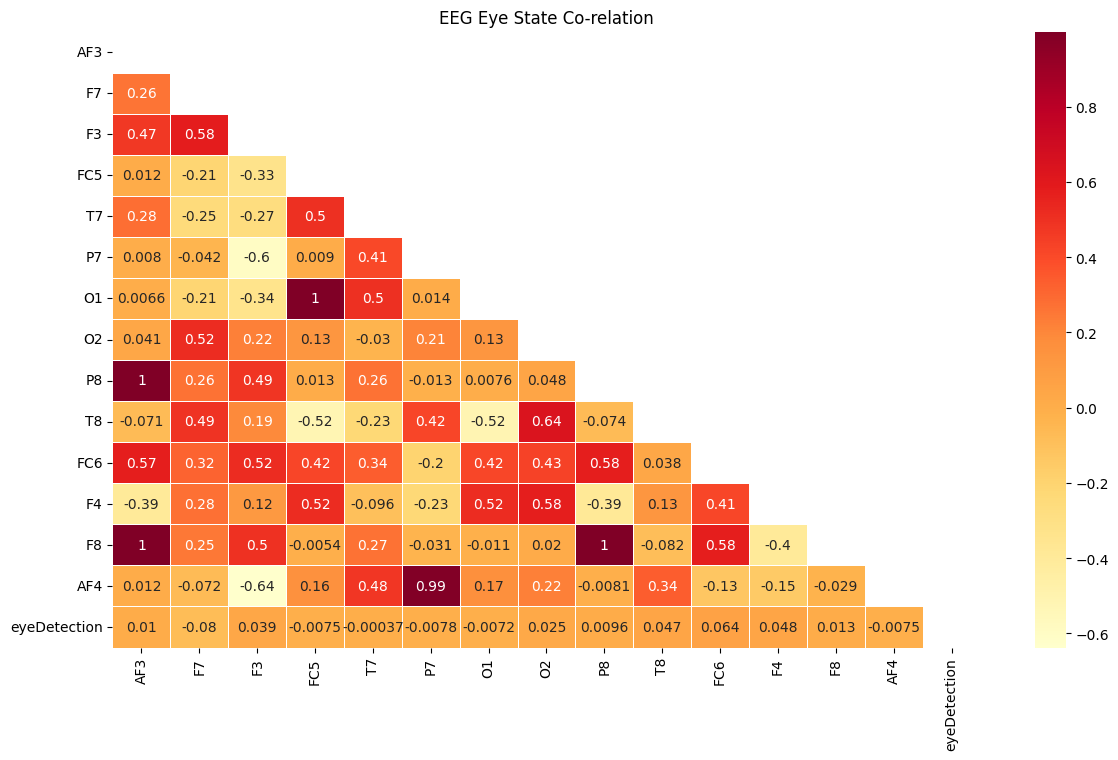

In [25]:
corr = df1.corr()
fig, axes = plt.subplots(figsize=(14, 8))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask, linewidths=.5, cmap='YlOrRd', annot=True)
plt.title("EEG Eye State Co-relation")
plt.show()

In [36]:
from scipy.stats import zscore

In [41]:
### Remove Outliers
def remove_outliers(df, z_thresh=2):
    numeric_cols = df.select_dtypes('number')
    z_scores = numeric_cols.apply(zscore)
    outlier_indices = (z_scores > z_thresh).any(axis=1)
    # Remove the outliers from the DataFrame
    df_no_outliers = df.loc[~outlier_indices]
    return df_no_outliers
df2 = remove_outliers(df1)
df2

,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,b'0'
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,b'0'
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,b'0'
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,b'0'
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,b'0'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14975,4281.03,3990.26,4245.64,4116.92,4333.85,4614.36,4074.87,4625.64,4203.08,4221.54,4171.28,4269.23,4593.33,4340.51,b'1'
14976,4276.92,3991.79,4245.13,4110.77,4332.82,4615.38,4073.33,4621.54,4194.36,4217.44,4162.56,4259.49,4590.26,4333.33,b'1'
14977,4277.44,3990.77,4246.67,4113.85,4333.33,4615.38,4072.82,4623.59,4193.33,4212.82,4160.51,4257.95,4591.79,4339.49,b'1'
14978,4284.62,3991.79,4251.28,4122.05,4334.36,4616.41,4080.51,4628.72,4200.00,4220.00,4165.64,4267.18,4596.41,4350.77,b'1'


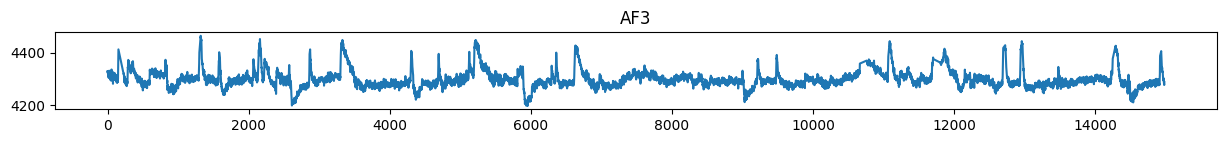

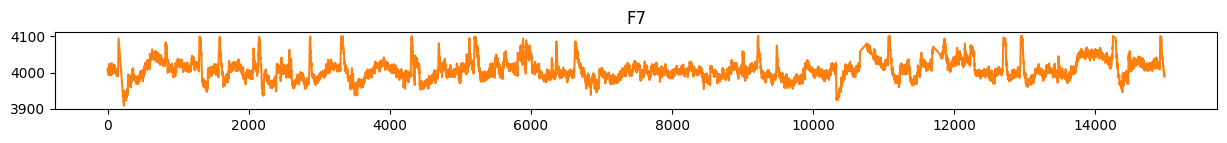

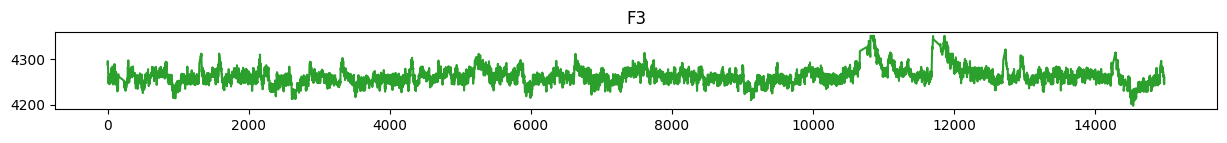

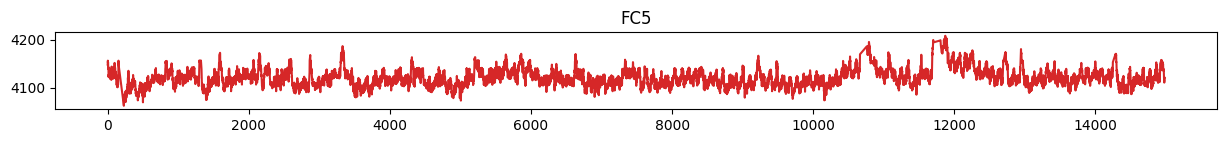

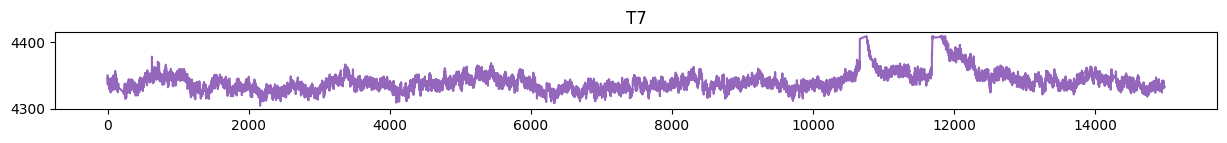

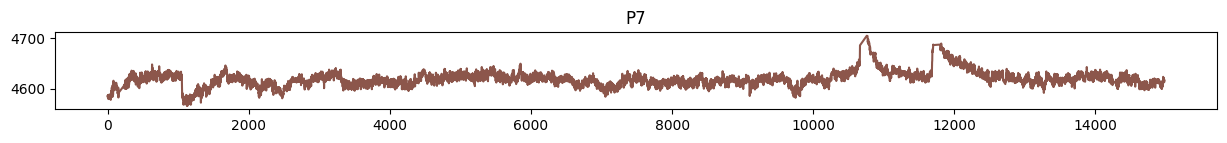

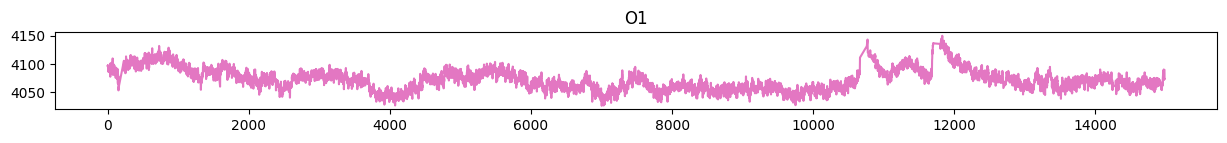

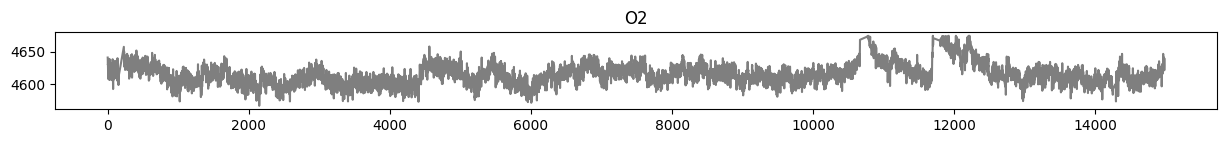

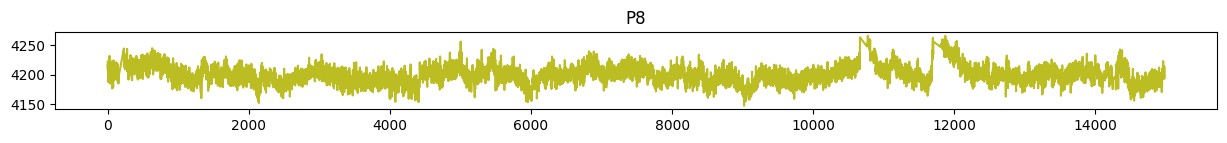

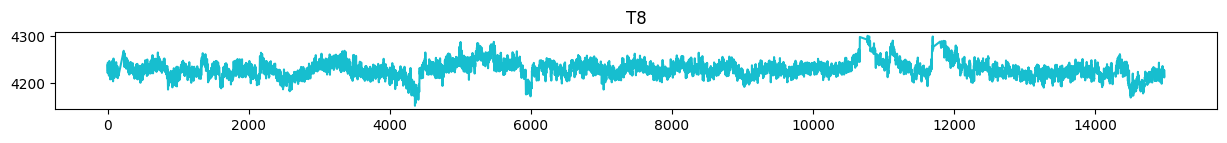

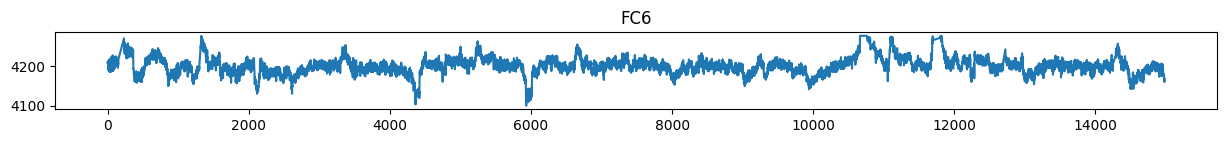

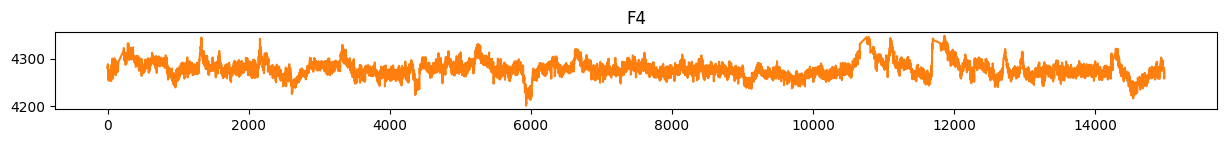

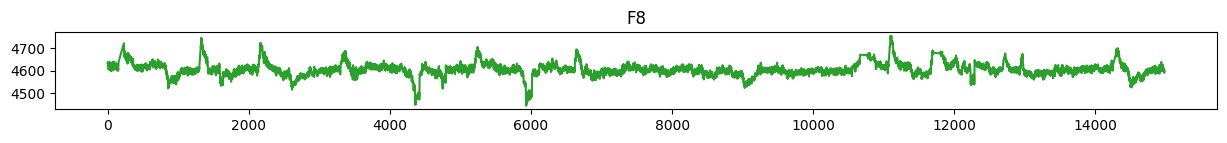

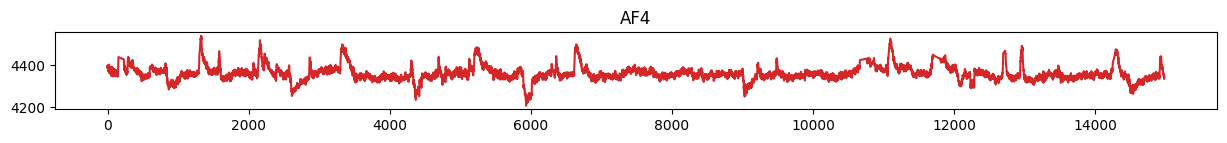

In [47]:
for f in df2.columns:
    if f =='eyeDetection':
        break
    else:
        df2[f].plot(figsize=(15, 1), color=next(color_cycle), title=f)
        plt.show()


In [32]:
from itertools import cycle
from scipy import stats
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

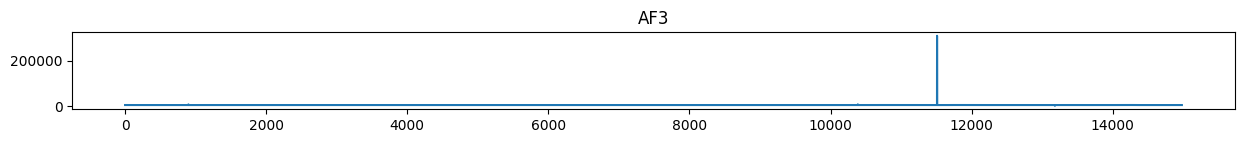

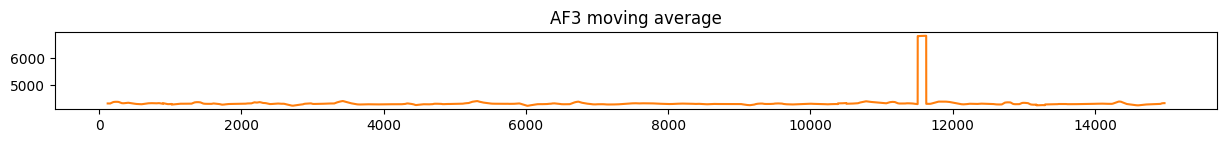

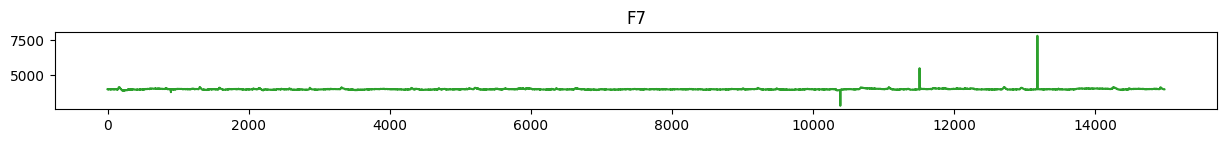

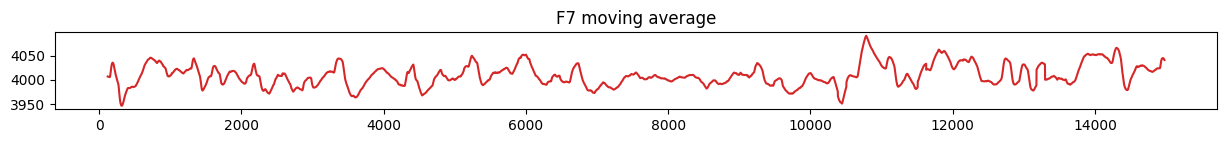

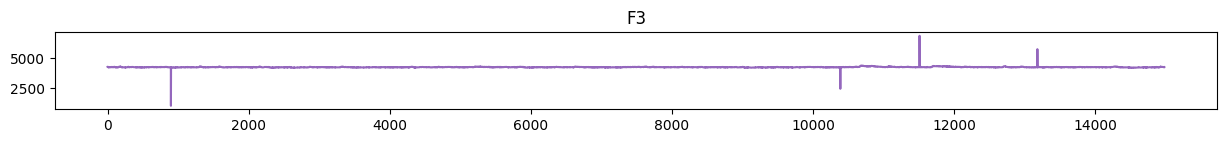

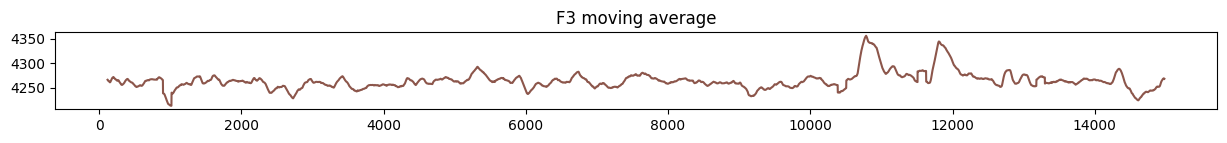

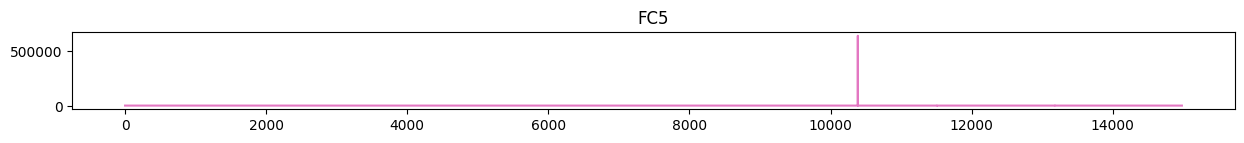

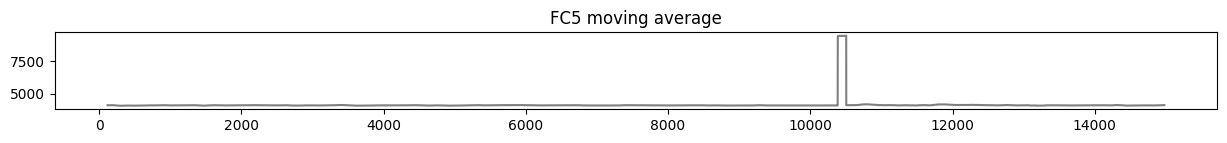

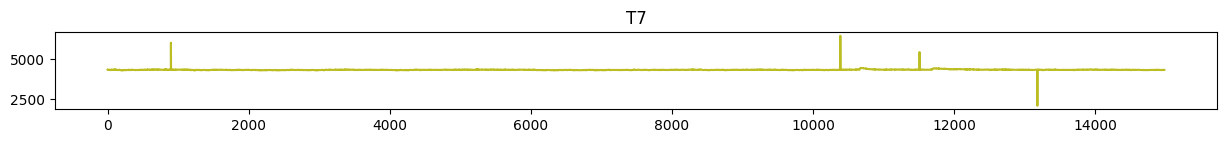

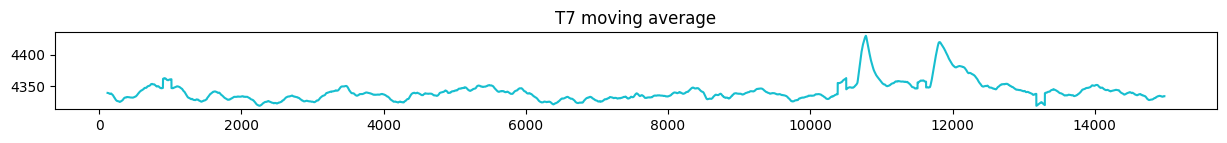

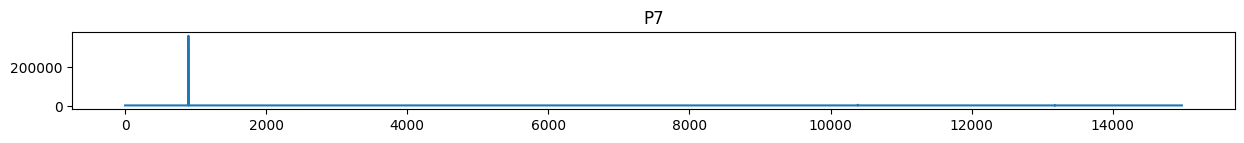

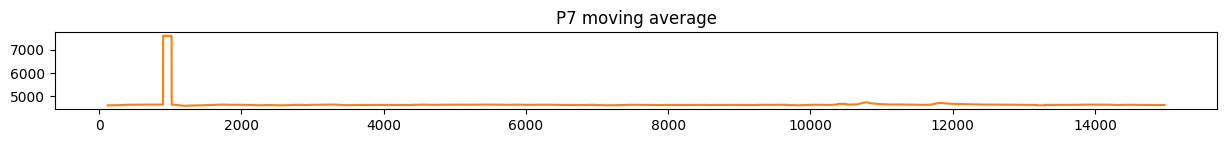

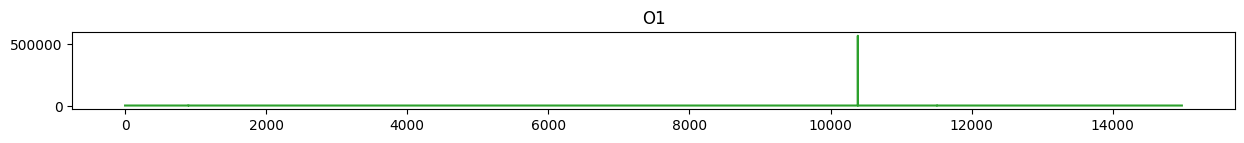

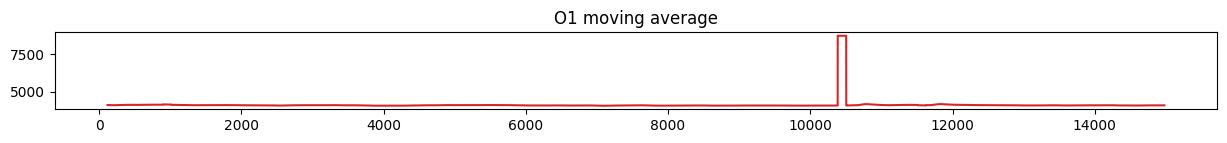

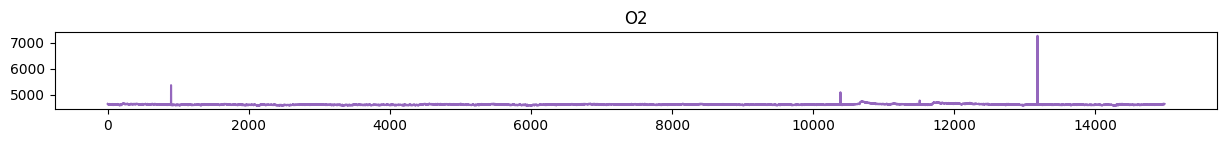

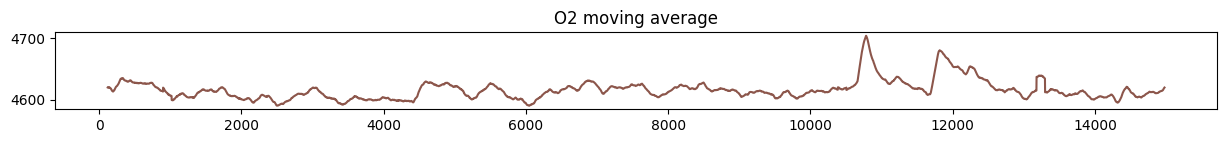

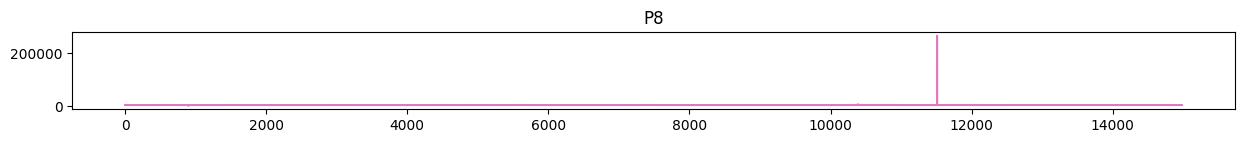

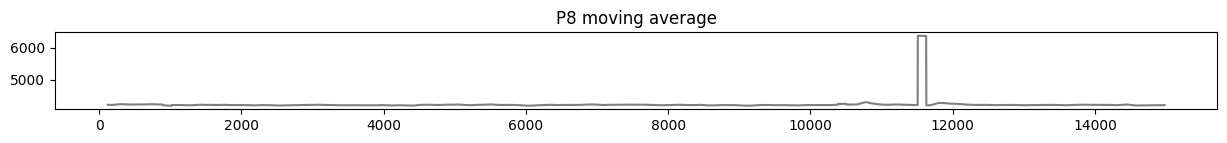

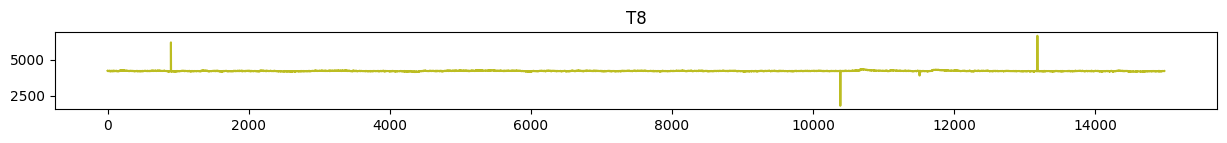

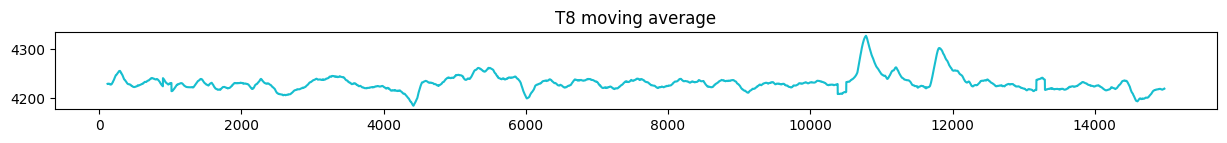

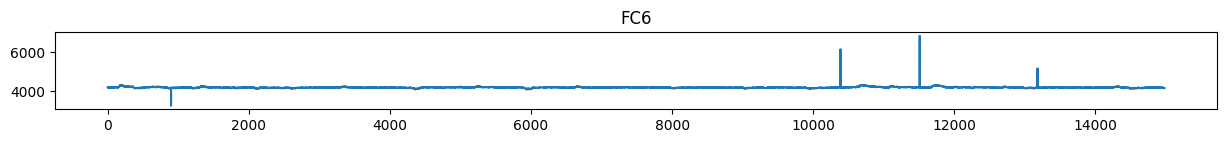

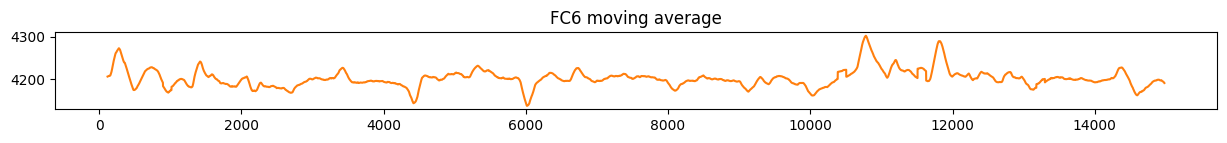

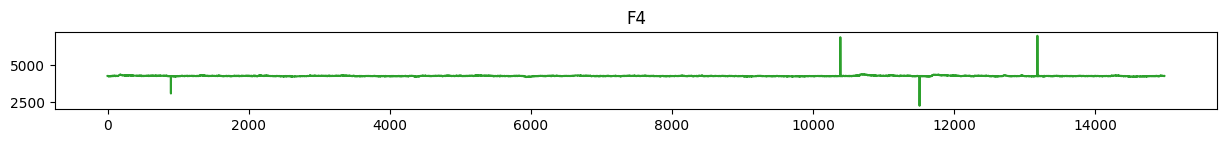

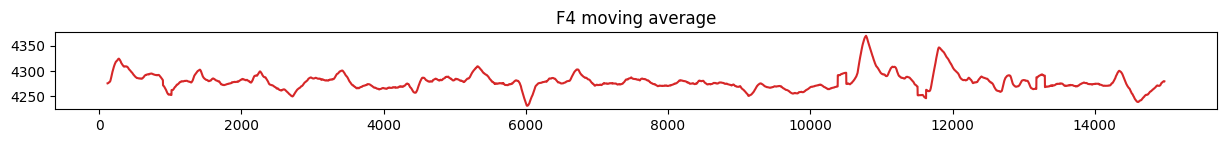

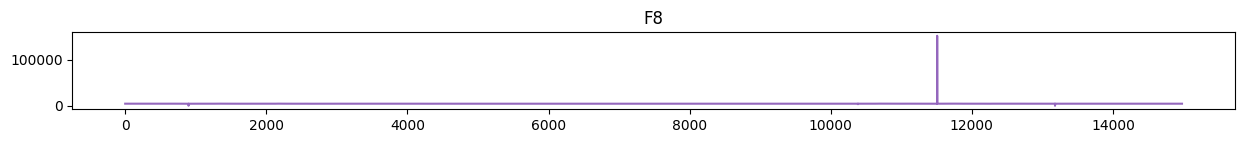

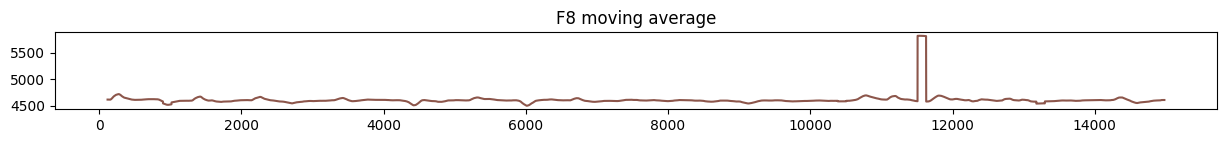

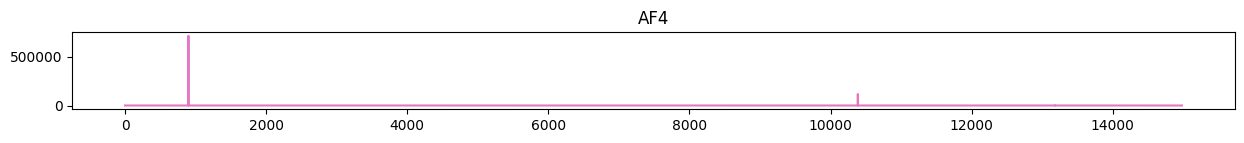

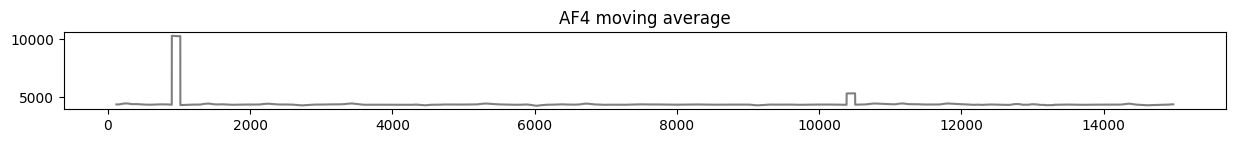

In [31]:
features = ['AF3','F7','F3','FC5','T7','P7','O1','O2','P8','T8','FC6','F4','F8','AF4']
df_ma = df1[features].copy()
for f in features:
    df_ma[f] = df1[f].rolling(window=120, center=False).mean()
    df1[f].plot(figsize=(15, 1), color=next(color_cycle), title=f)
    plt.show()
    df_ma[f].plot(figsize=(15, 1), color=next(color_cycle), title=f'{f} moving average')
    plt.show()

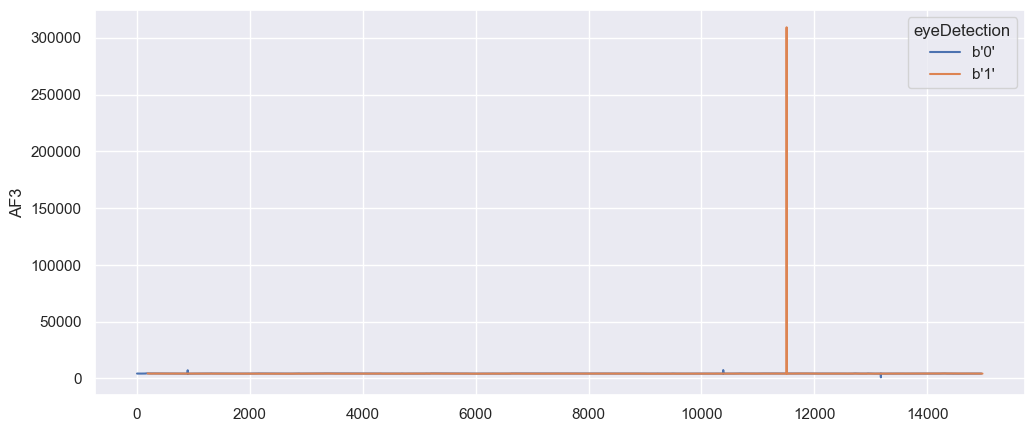

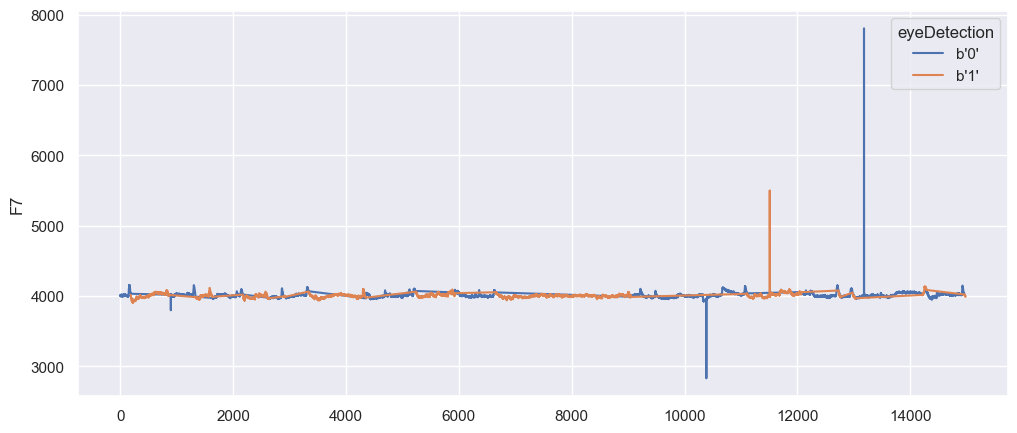

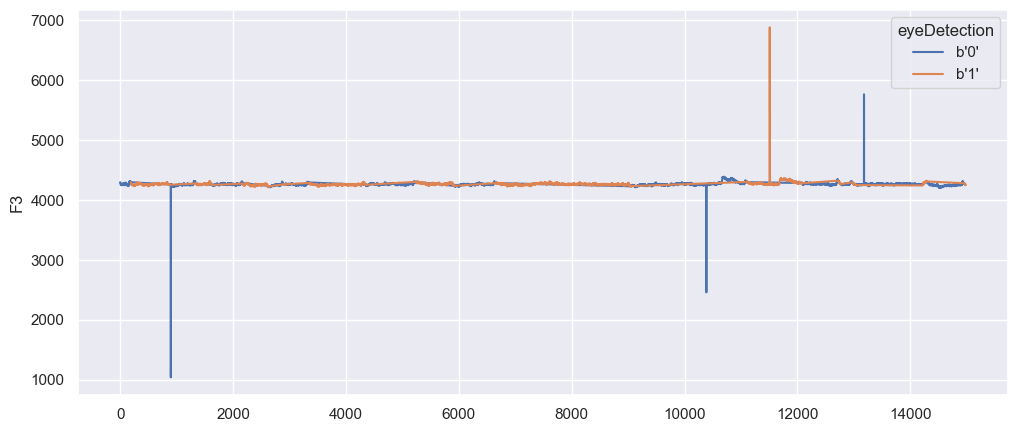

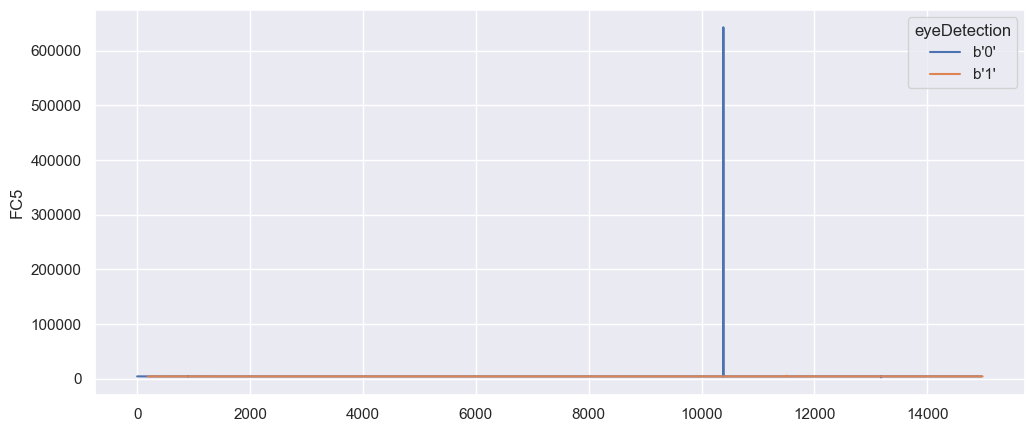

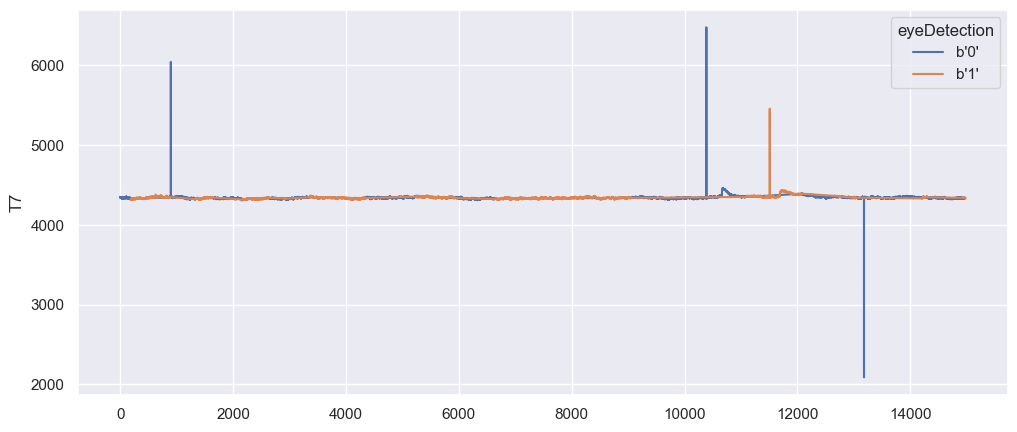

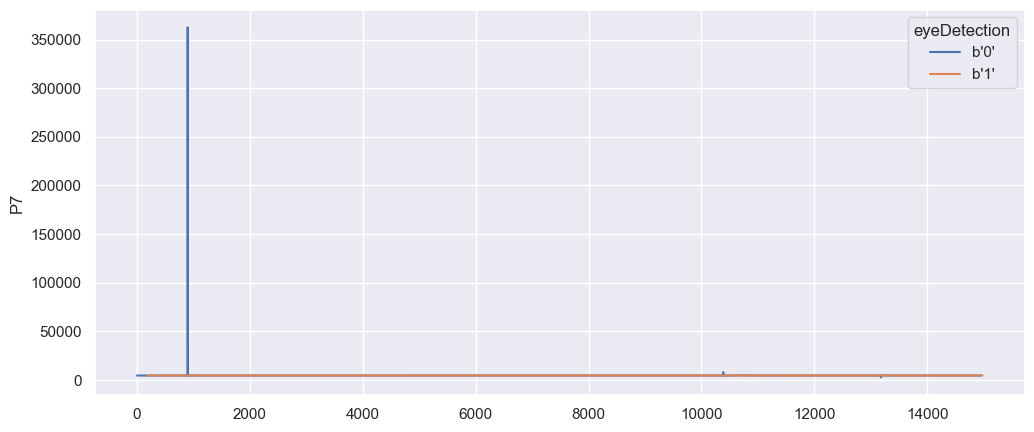

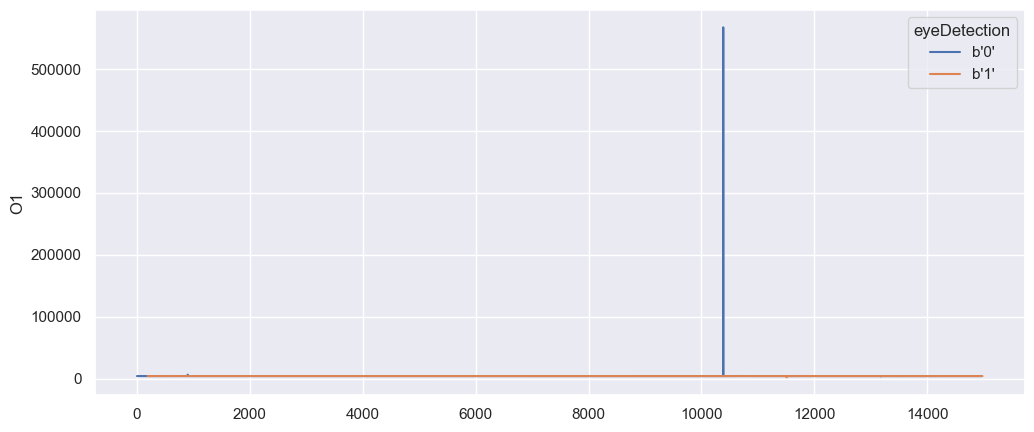

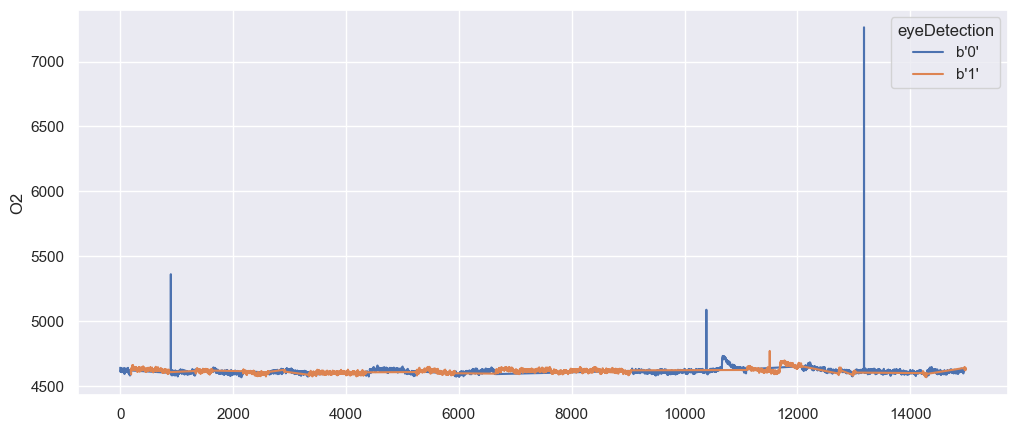

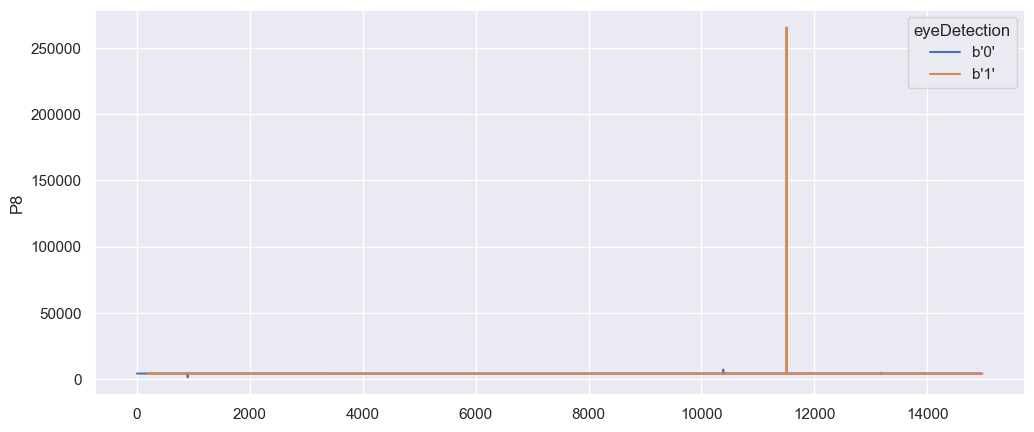

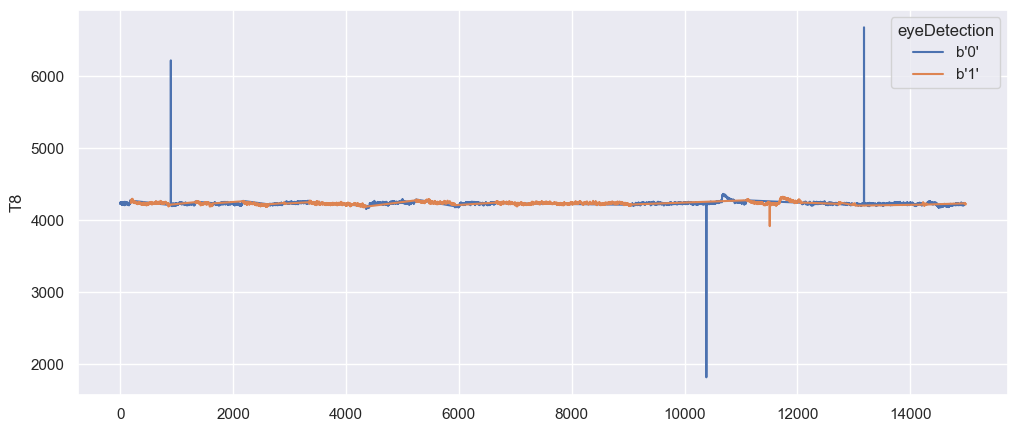

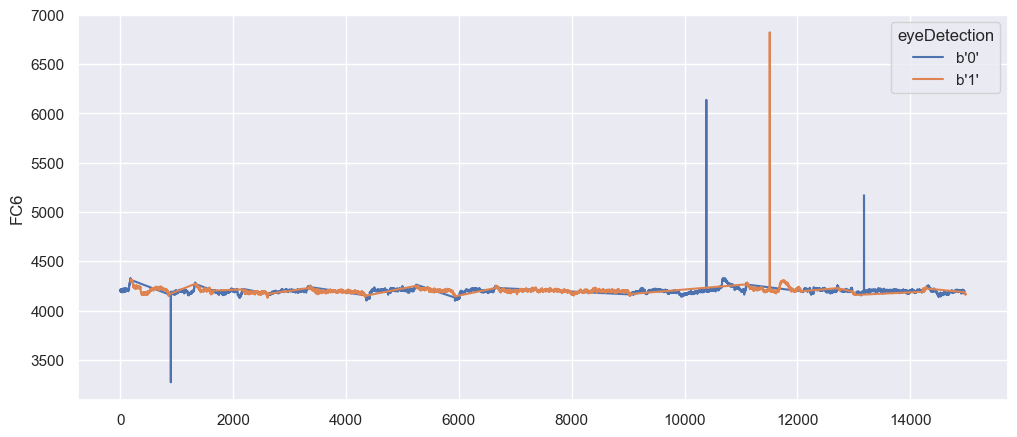

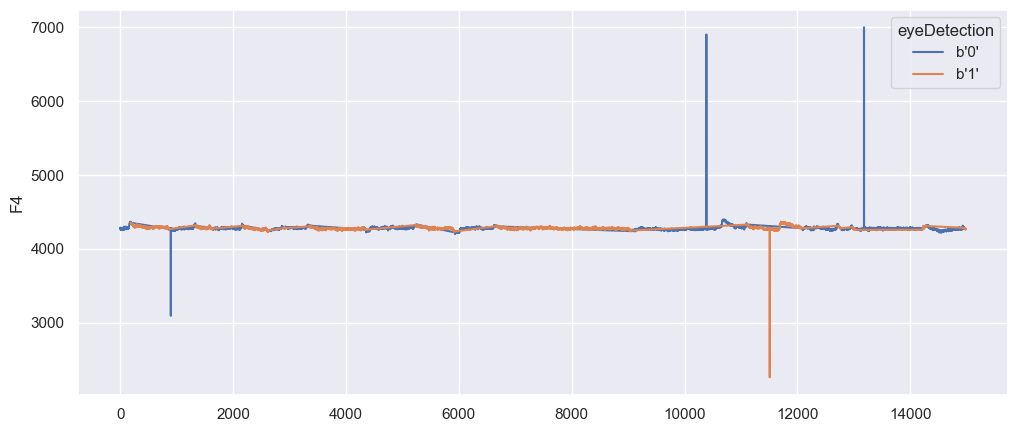

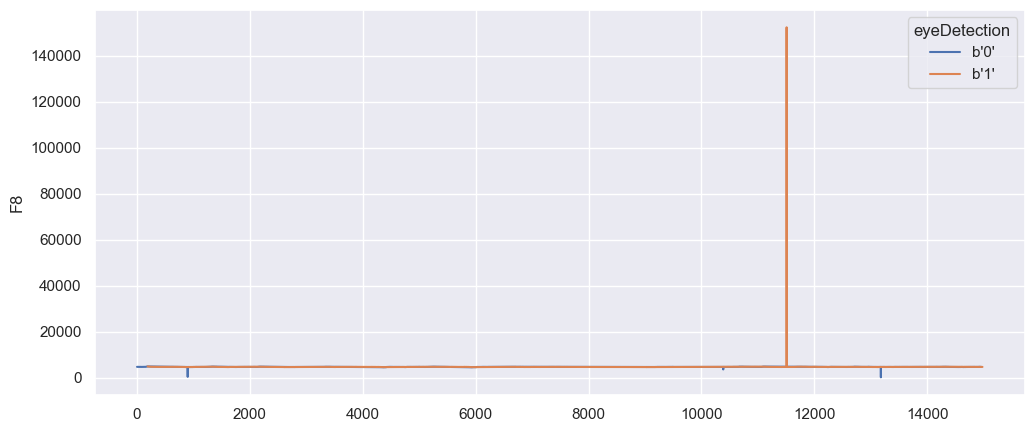

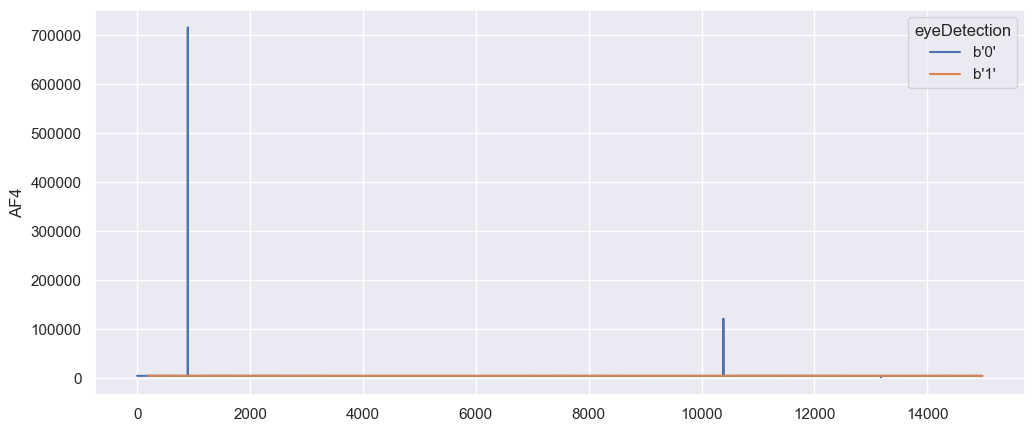

In [53]:
sns.set_theme(style='darkgrid')
for col in df1.columns[0:-1]:
    plt.figure(figsize=(12, 5))
    sns.lineplot(x=df1.index, y=col, data=df1, hue="eyeDetection")
    plt.show()

In [20]:
 df1['eyeDetection_level']=df1['eyeDetection'].apply(lambda x: int(x.decode()))

In [21]:
df1=df1.drop('eyeDetection', axis=1)

In [22]:
X=df1.drop('eyeDetection_level', axis=1)
y=df1['eyeDetection_level']

In [9]:
# train_percentage = 0.8
# split_point = int(len(X) * train_percentage)

# X_train = X[:split_point]
# X_test = X[split_point:]

# y_train = y[:split_point]
# y_test = y[split_point:]

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42)

In [121]:
# declare parameters
import xgboost as xgb
params = {
            'objective' : 'binary:logistic',
            'tree_method': 'hist',
            'eval_metric': 'logloss',
            'n_estimators':300,
            'predictor': 'cpu_predictor'
        }       
model = xgb.XGBClassifier(**params)
model.fit(X_train, y_train,
          early_stopping_rounds=200,
          eval_set=[(X_test,y_test)],
          verbose=True)

[0]	validation_0-logloss:0.60916
[1]	validation_0-logloss:0.56149
[2]	validation_0-logloss:0.52431
[3]	validation_0-logloss:0.49171
[4]	validation_0-logloss:0.46040
[5]	validation_0-logloss:0.43887
[6]	validation_0-logloss:0.42821
[7]	validation_0-logloss:0.41283
[8]	validation_0-logloss:0.40225
[9]	validation_0-logloss:0.39406
[10]	validation_0-logloss:0.38493
[11]	validation_0-logloss:0.37617
[12]	validation_0-logloss:0.36920
[13]	validation_0-logloss:0.35670
[14]	validation_0-logloss:0.35114
[15]	validation_0-logloss:0.34760
[16]	validation_0-logloss:0.34207
[17]	validation_0-logloss:0.33898
[18]	validation_0-logloss:0.33208
[19]	validation_0-logloss:0.32459
[20]	validation_0-logloss:0.32283
[21]	validation_0-logloss:0.31802
[22]	validation_0-logloss:0.31252
[23]	validation_0-logloss:0.30315
[24]	validation_0-logloss:0.29867
[25]	validation_0-logloss:0.29635
[26]	validation_0-logloss:0.29417
[27]	validation_0-logloss:0.29179
[28]	validation_0-logloss:0.28791
[29]	validation_0-loglos

[238]	validation_0-logloss:0.15201
[239]	validation_0-logloss:0.15204
[240]	validation_0-logloss:0.15199
[241]	validation_0-logloss:0.15159
[242]	validation_0-logloss:0.15202
[243]	validation_0-logloss:0.15223
[244]	validation_0-logloss:0.15208
[245]	validation_0-logloss:0.15206
[246]	validation_0-logloss:0.15195
[247]	validation_0-logloss:0.15185
[248]	validation_0-logloss:0.15187
[249]	validation_0-logloss:0.15186
[250]	validation_0-logloss:0.15184
[251]	validation_0-logloss:0.15191
[252]	validation_0-logloss:0.15144
[253]	validation_0-logloss:0.15141
[254]	validation_0-logloss:0.15142
[255]	validation_0-logloss:0.15177
[256]	validation_0-logloss:0.15164
[257]	validation_0-logloss:0.15159
[258]	validation_0-logloss:0.15188
[259]	validation_0-logloss:0.15179
[260]	validation_0-logloss:0.15150
[261]	validation_0-logloss:0.15123
[262]	validation_0-logloss:0.15143
[263]	validation_0-logloss:0.15103
[264]	validation_0-logloss:0.15089
[265]	validation_0-logloss:0.15085
[266]	validation_0-l

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, predictor='cpu_predictor',
              random_state=None, ...)

In [122]:
preds=model.predict(X_test)
gx_acc=accuracy_score(y_test, preds)
gx_acc

0.942367601246106

In [133]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
def objective(trial):
    C = trial.suggest_loguniform('C', 0.1, 10)
    gamma = trial.suggest_loguniform('gamma', 0.1, 10)
    
    svc = SVC(C=C, gamma=gamma, random_state=48)
    
    # split train test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=48, test_size=0.2, stratify=y, shuffle=True)
    
    # normalize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    svc.fit(X_train, y_train)
    
    # predict labels
    y_pred = svc.predict(X_test)
    
    return -accuracy_score(y_pred, y_test)  # Optuna minimizes the objective function, so negate the accuracy

# Run Optuna optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40)

# Get the best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

# Train the final SVM model with the best hyperparameters
best_svc = SVC(C=best_params['C'], gamma=best_params['gamma'], random_state=48)
best_svc.fit(X_train, y_train)

# Predict labels using the final model
y_pred_final = best_svc.predict(X_test)

# Calculate accuracy
final_accuracy = accuracy_score(y_pred_final, y_test)
print("Final Test Accuracy:", final_accuracy)

[I 2023-08-08 01:08:27,769] A new study created in memory with name: no-name-29d4e5cc-fc35-40aa-b069-ea394707501a
[I 2023-08-08 01:08:36,998] Trial 0 finished with value: -0.7703604806408545 and parameters: {'C': 0.4077509896327276, 'gamma': 1.1701875900409189}. Best is trial 0 with value: -0.7703604806408545.
[I 2023-08-08 01:08:45,465] Trial 1 finished with value: -0.6972630173564753 and parameters: {'C': 3.442527285353692, 'gamma': 0.21640779301397925}. Best is trial 0 with value: -0.7703604806408545.
[I 2023-08-08 01:08:54,870] Trial 2 finished with value: -0.7736982643524699 and parameters: {'C': 0.31280016845388814, 'gamma': 1.4489929368916632}. Best is trial 2 with value: -0.7736982643524699.
[I 2023-08-08 01:09:05,818] Trial 3 finished with value: -0.863150867823765 and parameters: {'C': 2.1152191662672393, 'gamma': 6.691619916642869}. Best is trial 3 with value: -0.863150867823765.
[I 2023-08-08 01:09:16,934] Trial 4 finished with value: -0.8477970627503337 and parameters: {'C

Best Hyperparameters: {'C': 9.510990299403757, 'gamma': 3.925406865365251}
Final Test Accuracy: 0.8744993324432577


#### LSTM

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,GRU, Dropout, BatchNormalization, Dense
from tensorflow.keras.callbacks import LearningRateScheduler

In [33]:
def custom_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

In [26]:
Ms=MinMaxScaler()
train_res=Ms.fit_transform(X_train)
test_res=Ms.fit_transform(X_test)

In [27]:
X_train_reshaped = train_res.reshape((train_res.shape[0], train_res.shape[1], 1))
X_test_reshaped = test_res.reshape((test_res.shape[0], test_res.shape[1], 1))

In [126]:
lstm = Sequential()

lstm.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
lstm.add(Dropout(0.2))
lstm.add(BatchNormalization())

lstm.add(LSTM(units=64, activation='relu', return_sequences=True))
lstm.add(Dropout(0.2))
lstm.add(BatchNormalization())

lstm.add(LSTM(units=32, activation='relu'))
lstm.add(Dropout(0.2))
lstm.add(BatchNormalization())

# For binary classification, use 'sigmoid' activation in the output layer
lstm.add(Dense(units=1, activation='sigmoid'))  # Sigmoid activation for binary classification

lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 14, 128)           66560     
                                                                 
 dropout_9 (Dropout)         (None, 14, 128)           0         
                                                                 
 batch_normalization_9 (Bat  (None, 14, 128)           512       
 chNormalization)                                                
                                                                 
 lstm_7 (LSTM)               (None, 14, 64)            49408     
                                                                 
 dropout_10 (Dropout)        (None, 14, 64)            0         
                                                                 
 batch_normalization_10 (Ba  (None, 14, 64)            256       
 tchNormalization)                                    

In [35]:
# Create a LearningRateScheduler callback
lr_schedule = LearningRateScheduler(custom_scheduler)

In [128]:
EPOCH = 30
BATCH_SIZE = 64
lstm.fit(X_train_reshaped,y_train, epochs=EPOCH, batch_size=BATCH_SIZE,validation_split=0.2, callbacks=[lr_schedule])

Epoch 1/30
132/132 [==============================] - 12s 58ms/step - loss: 0.7612 - accuracy: 0.5188 - val_loss: 0.7593 - val_accuracy: 0.5458 - lr: 0.0010
Epoch 2/30
132/132 [==============================] - 7s 52ms/step - loss: 0.7256 - accuracy: 0.5215 - val_loss: 0.7689 - val_accuracy: 0.5458 - lr: 0.0010
Epoch 3/30
132/132 [==============================] - 7s 52ms/step - loss: 0.7122 - accuracy: 0.5222 - val_loss: 0.7385 - val_accuracy: 0.5458 - lr: 0.0010
Epoch 4/30
132/132 [==============================] - 7s 55ms/step - loss: 0.7023 - accuracy: 0.5351 - val_loss: 0.6969 - val_accuracy: 0.5458 - lr: 0.0010
Epoch 5/30
132/132 [==============================] - 8s 57ms/step - loss: 0.6947 - accuracy: 0.5445 - val_loss: 0.7033 - val_accuracy: 0.5458 - lr: 0.0010
Epoch 6/30
132/132 [==============================] - 7s 51ms/step - loss: 0.6946 - accuracy: 0.5476 - val_loss: 0.6926 - val_accuracy: 0.5458 - lr: 0.0010
Epoch 7/30
132/132 [==============================] - 7s 52ms/s

In [129]:
loss, accuracy = lstm.evaluate(X_test_reshaped, y_test)

print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

141/141 [==============================] - 2s 13ms/step - loss: 1.0912 - accuracy: 0.4691
Test loss: 1.0912
Test accuracy: 0.4691


#### GRU

In [29]:
gru = Sequential()

gru.add(GRU(units=128, activation='relu', return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
gru.add(Dropout(0.2))
gru.add(BatchNormalization())

gru.add(GRU(units=64, activation='relu', return_sequences=True))
gru.add(Dropout(0.2))
gru.add(BatchNormalization())

gru.add(GRU(units=32, activation='relu'))
gru.add(Dropout(0.2))
gru.add(BatchNormalization())

# For binary classification, use 'sigmoid' activation in the output layer
gru.add(Dense(units=1, activation='sigmoid'))  # Sigmoid activation for binary classification

gru.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
gru.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 14, 128)           50304     
                                                                 
 dropout (Dropout)           (None, 14, 128)           0         
                                                                 
 batch_normalization (Batch  (None, 14, 128)           512       
 Normalization)                                                  
                                                                 
 gru_1 (GRU)                 (None, 14, 64)            37248     
                                                                 
 dropout_1 (Dropout)         (None, 14, 64)            0         
                                                                 
 batch_normalization_1 (Bat  (None, 14, 64)            256       
 chNormalization)                                     

In [36]:
EPOCH = 30
BATCH_SIZE = 64
gru.fit(X_train_reshaped,y_train, epochs=EPOCH, batch_size=BATCH_SIZE,validation_split=0.2, callbacks=[lr_schedule])

Epoch 1/30
132/132 [==============================] - 11s 49ms/step - loss: 0.7918 - accuracy: 0.5088 - val_loss: 0.7047 - val_accuracy: 0.5458 - lr: 0.0010
Epoch 2/30
132/132 [==============================] - 6s 43ms/step - loss: 0.7360 - accuracy: 0.5166 - val_loss: 0.6970 - val_accuracy: 0.5458 - lr: 0.0010
Epoch 3/30
132/132 [==============================] - 5s 42ms/step - loss: 0.7152 - accuracy: 0.5268 - val_loss: 0.6952 - val_accuracy: 0.5458 - lr: 0.0010
Epoch 4/30
132/132 [==============================] - 7s 54ms/step - loss: 0.7068 - accuracy: 0.5274 - val_loss: 0.6916 - val_accuracy: 0.5458 - lr: 0.0010
Epoch 5/30
132/132 [==============================] - 6s 43ms/step - loss: 0.6970 - accuracy: 0.5407 - val_loss: 0.6890 - val_accuracy: 0.5458 - lr: 0.0010
Epoch 6/30
132/132 [==============================] - 5s 41ms/step - loss: 0.6928 - accuracy: 0.5433 - val_loss: 0.6897 - val_accuracy: 0.5458 - lr: 0.0010
Epoch 7/30
132/132 [==============================] - 5s 41ms/s

In [37]:

loss, accuracy = gru.evaluate(X_test_reshaped, y_test)

print(f"Test loss: {loss:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

141/141 [==============================] - 1s 9ms/step - loss: 0.6911 - accuracy: 0.5307
Test loss: 0.6911
Test accuracy: 0.5307
